In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob
import xgboost

In [2]:
##Proof of concept
os.chdir(r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/')
df = pd.read_csv('GA_spectra_FINAL_3-4-22.csv') ##very different results than GA_spectra

##Variables from Byrd et al. 2018:
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df

# g = sns.scatterplot(x = 'NIR_band', y = 'Mean_Biomass', data = df)
# plt.show()

,2000_B1,2000_B2,2000_B3,2000_B4,2000_B5,2000_B6,2000_B7,2001_B1,2001_B2,2001_B3,...,Red_band,NIR_band,SWIR1_band,SWIR2_band,savi,wdrvi5,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r
0,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0347,0.0641,0.0540,0.0333,0.073647,-0.039700,-0.001439,0.085803,-0.316222,-0.020588
1,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0389,0.0788,0.0844,0.0532,0.096892,0.006386,-0.073810,0.223881,-0.193939,0.155266
2,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0374,0.0895,0.0748,0.0410,0.124661,0.089470,-0.007958,0.084165,-0.371648,0.045918
3,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0321,0.1092,0.0647,0.0350,0.180337,0.259516,0.011024,0.084629,-0.514563,0.043219
4,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0610,0.1242,0.1149,0.0655,0.138354,0.008936,-0.048362,0.038640,-0.309436,0.035573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,0.0549,0.1367,0.1094,0.0613,0.177415,0.109128,-0.047702,0.134272,-0.380808,0.055077
204,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,0.0368,0.0932,0.0731,0.0405,0.134286,0.117506,-0.055199,0.116848,-0.394166,0.047865
205,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,0.0346,0.0834,0.0555,0.0303,0.118447,0.093054,-0.052055,0.131075,-0.467018,-0.066256
206,0.0361,0.0487,0.0495,0.1084,0.1146,0.2920,0.0592,0.0306,0.0401,0.0425,...,0.0475,0.0905,0.0928,0.0597,0.101097,-0.024259,0.053215,0.126649,-0.205060,0.113806


In [3]:
##First go at machine learning, using the methods of Byrd et al 2018

##Need (from table 3)=: SAVI, normalized difference green/blue index, wide dynamic range vegetation index 5, ndvi red/green, \
##  ndvi swir2/nir, ndvi swir2/red, site? (site may be important when combining GA, VA, and MA data)

##Random Forest test! REMEMBER: by combining landsat 5 and 8 bands, you are grouping bands with slightly different wavelengths. 
##ONLY INDICES to account for this

##From: https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

df = df[df['ndvi'].notna()] ##remove rows with NaN for columns used in the model 

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xargs=df[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi']] 
yargs=df['Mean_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

## Feature Scaling - is this necessary?
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# xargs_train = sc.fit_transform(xargs_train)
# xargs_test = sc.transform(xargs_test)

from sklearn.ensemble import RandomForestRegressor
# from sklearn.impute import SimpleImputer

##Create a Gaussian Classifier
reg_x=RandomForestRegressor(n_estimators=100, random_state = 0) ##play with random state

##Train the model using the training sets y_pred=clf.predict(xargs_test)
reg_x.fit(xargs_train, yargs_train)
y_pred=reg_x.predict(xargs_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))

r_square = metrics.r2_score(yargs_test, y_pred)
print(r_square) ##pretty low (0.29), all things considered
print(reg_x.score(xargs_test, yargs_test)) ##same as above, why?


Mean Absolute Error: 401.15938130952384
Mean Squared Error: 280242.7050352075
Root Mean Squared Error: 529.3795472392256
-0.24265859874974427
-0.24265859874974427


In [4]:
# plt.scatter(xargs,yargs, color='red') ##plotting real points
df['Mean_Biomass'].describe()

count     208.000000
mean      663.391943
std       478.262638
min       106.366000
25%       312.882500
50%       476.735250
75%       854.051500
max      2452.424000
Name: Mean_Biomass, dtype: float64

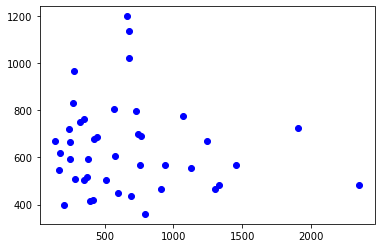

-0.09984929920335635

In [5]:
plt.scatter(yargs_test, y_pred, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.show()

np.corrcoef(yargs_test, y_pred)[0, 1]
##the individual bands were better by themselves

In [6]:
##xgboost - seems to perform worse than random forest, at least with initial data
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## split data into X and y
xargs=df[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi']] 
yargs=df['Mean_Biomass'] 

## split data into train and test sets
size_x = 0.2
seed = 0
x_xg_train, x_xg_test, y_xg_train, y_xg_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed)

##fit model no training data
xg_reg = XGBClassifier()
xg_reg.fit(x_xg_train, y_xg_train)

##make predictions for test data
y_xg_pred = xg_reg.predict(x_xg_test)
# predictions = [round(value) for value in y_pred]

##evaluate predictions

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_xg_test, y_xg_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_xg_test, y_xg_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_xg_test, y_xg_pred)))

r_square = metrics.r2_score(y_xg_test, y_xg_pred)
print(r_square)
print(reg_x.score(x_xg_test, y_xg_test))

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:45:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Absolute Error: 563.235899659864
Mean Squared Error: 542753.3410860215
Root Mean Squared Error: 736.717952194747
-1.40668925250334
-0.24265859874974427


In [ ]:
##Major question: why is the averaged dataset random forest worse than the individual plots rf? Sample size?
##Or is zonal_stats pixel extraction not what you think it is?